# Compare SNOTEL temperature observations to CW3E forcing
D. Tijerina, 5/2023

This script reads in SNOTEL observations queried from Hydrodata and compares to CW3E forcing. The notebook is broken up into these sections:  
1. Read in SNOTEL observations and metadata; organize into pandas dataframes
2. Read in CW3E forcing over CONUS2 and extract indices for CONUS2 grid cells that are common to the SNOTEL observations; organize all data
3. Compute statistics between CW3E and SNOTEL observations
4. Create summary plots, maps, and individual station timeseries


Inputs:
- SNOTEL Metadata csv file of stations from a Hydrodata query (from point_observations.ipynb)
- SNOTEL Observation data csv file of stations from a Hydrodata query (from point_observations.ipynb)

Outputs:
- Matched CW3E/ParFlow temperature csv
- Rematched Metadata file csv
- Rematched SNOTEL observation file csv
- Summary station SNOTEL csv containing station info, CONUS x and y, averages, statistics
- Timeseries of SNOTEL variable vs. ParFlow at individual stations
- Summary plots/maps

Notes: 
- Need to add a basemap to summary plots (Geopandas? Basemap from matplot.toolkit?)

In [3]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd

In [17]:
### Directory to save CSV outputs
organized_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/SNOTEL/precip_temp/Organized_csv'

### Where you want to save plots, etc. to
#plot_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Figures'
#plot_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/SNOTEL/precip_temp/Figures'
plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/Figures/SNOTEL/precip_temp/Figures'
print(f'Figures saving to: {plot_dir}')

# need to change water year and number of days
water_year = 2003
no_days = 365 
variable = 'CONUS2_Temp_C'

# CONUS2 domain
ny = 3256
nx = 4442

Figures saving to: /hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/spinup_Validation/Figures/SNOTEL/precip_temp/Figures


In [5]:
from PIL import Image

# Read in CONUS2 mask for map plot border
CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
#CONUS2_mask = Image.open('/home/dtt2/CONUS2/shape_files/CONUS2_HUC2_boundaries_clipped.tif')
mask_array = np.array(CONUS2_mask)

##### Names of observation csv files, these are usually saved from Hydrodata

In [6]:
# Files for SNOTEL average temperature observations (in C) from Hydrodata
data_file = 'Temperature_obs_daily_avg_WY2003.csv' 
metadata_file = 'Temperature_obs_metadata_daily_avg_WY2003.csv'

##### Name of path and file name of PFB reading in
CW3E (CONUS2 Forcing)

In [7]:
# path to daily forcing PFB files
pfb_read_path = '/hydrodata/forcing/processed_data/CONUS2/NLDAS3/daily/WY2003'
# This is the partial name of the pfb, without the timestamp or .pfb file extension
# (for example, 'NLDAS.APCP.daily.sum.008.pfb' -> 'NLDAS.APCP.daily.sum')
pfb_name = 'NLDAS.Temp.daily.mean' 

##### Create file names for all files you will save out
These include:
- CSV of ParFlow or CW3E modeled values from pfb at station-matched CONUS2 x, y
- Rematched observation csv file (this is a reorganized version of `data_file`
- Rematched observation metadata csv file (this is a reorganized version of `metadata_file`
- Summary statistics csv with station info and stats for each station

In [8]:
### Name files you will save out
# names of csv files for model and observations that contain the same stations
pf_matched_csv = f'CW3E_Daily_matched_{variable}_{water_year}.csv'
snotel_matched_csv = f'SNOTEL_Daily_matched_{variable}_{water_year}.csv'
metadata_matched_csv = f'SNOTEL_metadata_matched_{variable}_{water_year}.csv'
# summary stats
summary_stats_csv = f'Summary_Stations_SNOTEL_{variable}_CONUS2_WY{water_year}.csv'

# 1. Read in SNOTEL observations and organize

### SNOTEL Avg Daily Temperature 

In [6]:
obs_data = pd.read_csv(f'{organized_dir}/{data_file}', index_col=['site_id'])
obs_data  = obs_data.drop(columns=['Unnamed: 0'])
obs_data = obs_data.loc[(obs_data['num_obs']>340)] # I arbitrarily set this to only include sites with more than 340 days of observations
obs_data

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,0.6,3.4,4.3,7.2,8.4,8.9,9.2,8.0,6.8,2.8,...,13.1,13.3,13.9,13.5,16.2,16.1,15.0,9.8,8.7,364
1005:CO:SNTL,5.2,3.4,0.6,1.8,5.0,3.5,3.8,3.5,4.9,4.5,...,7.1,9.4,7.5,7.6,9.0,8.7,6.7,8.0,7.6,365
1006:NV:SNTL,0.4,0.6,4.7,4.4,6.4,8.6,9.7,10.0,10.8,12.2,...,15.1,16.3,16.7,16.0,16.6,16.7,17.2,16.5,15.8,363
1008:MT:SNTL,-2.9,-1.0,-0.3,0.6,-0.1,2.5,5.3,2.7,4.8,5.4,...,8.2,7.8,5.7,11.4,7.9,5.9,5.5,2.4,4.2,365
1009:MT:SNTL,-1.2,-0.4,0.6,2.0,1.3,3.1,5.4,3.1,3.7,5.3,...,8.0,8.9,6.3,11.9,8.0,6.0,6.0,3.3,3.9,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985:WA:SNTL,5.6,7.8,7.9,8.7,10.3,13.0,13.6,12.4,12.0,6.8,...,16.7,16.6,17.3,19.8,19.7,19.4,19.7,17.2,16.7,365
988:ID:SNTL,2.1,4.0,6.0,5.2,6.7,8.9,8.2,7.5,7.2,3.5,...,11.7,10.0,10.0,14.5,13.7,11.9,11.6,9.1,8.2,364
989:ID:SNTL,3.9,5.8,5.1,6.8,6.8,9.3,10.7,10.1,9.2,4.1,...,13.3,13.4,14.8,15.6,16.7,17.3,17.7,15.4,18.2,365


In [7]:
metadata = pd.read_csv(f'{organized_dir}/{metadata_file}', index_col=['site_id'])
metadata  = metadata.drop(columns=['Unnamed: 0'])
# also remove the sites with less than 340 obs from the metadata
metadata = metadata[metadata.index.isin(obs_data.index)]
# add number of observations column from the obs_data df
metadata['num_obs'] = obs_data['num_obs']
obs_data = obs_data.drop(columns=['num_obs'])
metadata

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,file_path,county_name,elevation,shef_id,acton_id,conus1_x,conus1_y,conus2_x,conus2_y,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,SNOTEL station,NRCS,Annie Springs,1000:OR:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,42.87007,-122.16518,OR,180102030101,...,/hydrodata/national_obs/point_meteorology/NRCS...,Klamath,6010.0,ANSO3,22G06S,NaN,NaN,258,2286,364
1005:CO:SNTL,SNOTEL station,NRCS,Ute Creek,1005:CO:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,37.61480,-105.37322,CO,130100020604,...,/hydrodata/national_obs/point_meteorology/NRCS...,Costilla,10734.0,UTCC2,05M17S,1063.0,495.0,1490,1448,365
1006:NV:SNTL,SNOTEL station,NRCS,Lewis Peak,1006:NV:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,40.35720,-116.86470,NV,160401070903,...,/hydrodata/national_obs/point_meteorology/NRCS...,Lander,7370.0,LWPN2,16J01S,137.0,957.0,592,1908,363
1008:MT:SNTL,SNOTEL station,NRCS,Onion Park,1008:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.91348,-110.85360,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,7410.0,ONPM8,10C22S,753.0,1575.0,1196,2499,365
1009:MT:SNTL,SNOTEL station,NRCS,Stringer Creek,1009:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.92690,-110.90198,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,6550.0,STCM8,10C23S,750.0,1577.0,1193,2501,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985:WA:SNTL,SNOTEL station,NRCS,Sourdough Gulch,985:WA:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.23718,-117.39438,WA,170601030202,...,/hydrodata/national_obs/point_meteorology/NRCS...,Asotin,4000.0,SGUW1,17C06S,245.0,1601.0,709,2531,365
988:ID:SNTL,SNOTEL station,NRCS,Hidden Lake,988:ID:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,48.89370,-116.75748,ID,170101040502,...,/hydrodata/national_obs/point_meteorology/NRCS...,Boundary,5040.0,HDLI1,16A12S,361.0,1879.0,825,2796,364
989:ID:SNTL,SNOTEL station,NRCS,Moscow Mountain,989:ID:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.80500,-116.85350,ID,170603061002,...,/hydrodata/national_obs/point_meteorology/NRCS...,Latah,4700.0,MSCI1,16C02S,300.0,1653.0,763,2580,365


# 2. Read in CW3E forcing and organize

### CW3E (CONUS2 Forcing)

In [8]:
# make CONUS2 x and y into arrays for the for loop
conusy = np.asarray(metadata['conus2_y'],dtype = 'int')
conusx = np.asarray(metadata['conus2_x'],dtype = 'int')

#### Read in pfb and extract data at each CONUS2 index pair included in the observations/metadata files
*** You should only have to do this one time for each variable. The saved CSVs from this section are read back in in Section 3.

In [9]:
# temperature
# Set up arrays 
pf_full_array = np.zeros((no_days, ny, nx))
pf_matched = np.zeros(obs_data.shape)

### READ STREAMFLOW PFBs ###
#Read in CONUS2 daily streamflow PFBs and save as df in flow_df, convert to total accumulated in m^3/h to mean daily in cms
for i in range(no_days):
    step = str(int(i+1)).rjust(3, '0')
    ### CHECK THIS PATH TO CONFIRM CORRECT OBS FILE ###
    pf_pfb = np.squeeze(read_pfb(f'{pfb_read_path}/{pfb_name}.{step}.pfb')) 
    pf_full_array[i,...] = pf_pfb
    print(f'reading {variable} for day {step}')
    for j in range(len(obs_data.index)):
        if conusy[j] < 0:
            pf_matched[j] = 'nan'
            #print('Gage is outside of CONUS2 range')
        else:
            pf_matched[j,i] = pf_full_array[i, conusy[j], conusx[j]]
            #print('Finding value in CONUS2 grid')

reading CONUS2_Temp_C for day 001
reading CONUS2_Temp_C for day 002
reading CONUS2_Temp_C for day 003
reading CONUS2_Temp_C for day 004
reading CONUS2_Temp_C for day 005
reading CONUS2_Temp_C for day 006
reading CONUS2_Temp_C for day 007
reading CONUS2_Temp_C for day 008
reading CONUS2_Temp_C for day 009
reading CONUS2_Temp_C for day 010
reading CONUS2_Temp_C for day 011
reading CONUS2_Temp_C for day 012
reading CONUS2_Temp_C for day 013
reading CONUS2_Temp_C for day 014
reading CONUS2_Temp_C for day 015
reading CONUS2_Temp_C for day 016
reading CONUS2_Temp_C for day 017
reading CONUS2_Temp_C for day 018
reading CONUS2_Temp_C for day 019
reading CONUS2_Temp_C for day 020
reading CONUS2_Temp_C for day 021
reading CONUS2_Temp_C for day 022
reading CONUS2_Temp_C for day 023
reading CONUS2_Temp_C for day 024
reading CONUS2_Temp_C for day 025
reading CONUS2_Temp_C for day 026
reading CONUS2_Temp_C for day 027
reading CONUS2_Temp_C for day 028
reading CONUS2_Temp_C for day 029
reading CONUS2

In [10]:
# Organize PF daily matched array with the same index and dates as the obs_data
pf_match_df = pd.DataFrame(pf_matched)
pf_match_df = pf_match_df.set_index(obs_data.index)
column_headers = list(obs_data.columns.values)
pf_match_df.columns = column_headers

In [11]:
# drop any na's and convert temperature
pf_match_df_new = pf_match_df.dropna()
pf_match_df_new = pf_match_df_new-273.15 #convert 
pf_match_df_new

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,0.452749,-0.037787,4.163962,4.602537,7.657367,9.320978,11.255205,11.361138,10.214299,9.273023,...,11.843220,13.681202,15.593554,15.734534,16.152535,15.613653,18.629292,18.540018,17.434109,10.731911
1005:CO:SNTL,7.262504,5.576400,2.542334,-0.998446,1.500982,4.885522,4.342208,5.858128,5.484463,5.503211,...,6.722181,6.536026,7.585606,9.684070,8.246058,9.331012,9.133006,6.540067,6.428365,8.773644
1006:NV:SNTL,4.305715,-0.498291,-1.082200,3.610405,3.261910,6.601198,9.306240,10.216397,10.762437,11.066764,...,13.564827,14.817957,15.877203,17.183832,18.160396,17.309611,17.601383,18.132715,18.499653,16.951897
1008:MT:SNTL,-0.390237,-3.318083,-1.566407,-1.190700,0.375963,-0.877002,2.052700,5.387891,2.719790,4.602048,...,4.972007,2.549454,7.724030,6.847152,6.160591,11.850128,8.385088,7.114097,6.946448,2.429783
1009:MT:SNTL,0.831790,-2.273385,-0.322611,-0.231768,1.503755,0.481219,3.402945,6.216261,3.834474,5.532480,...,6.023805,3.669542,8.711857,8.045283,7.496431,12.761174,9.297189,8.082850,7.956637,3.467466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985:WA:SNTL,5.026364,5.092144,7.288812,7.775261,8.964054,10.727584,12.454374,13.034676,12.119218,12.177745,...,12.383077,13.538493,16.644876,17.042835,17.625874,19.898822,19.709720,19.964227,20.109001,17.561543
988:ID:SNTL,1.163858,2.880718,2.659686,6.058405,3.857164,6.462546,9.208766,6.907738,6.502481,6.695914,...,7.062271,8.007008,10.950627,8.908328,8.967526,14.145237,14.200049,13.475189,13.338653,9.737845
989:ID:SNTL,2.999183,3.724621,4.943496,4.316966,6.927923,7.145573,9.719069,10.252836,9.546348,9.322403,...,9.320581,9.860283,11.887966,12.322485,13.712752,14.010341,14.868322,15.857834,16.371119,14.313235


In [12]:
# parse down observation df to include the same stations as the final ParFlow matched df
obs_data_new = obs_data[obs_data.index.isin(pf_match_df_new.index)]
obs_data_new

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,0.6,3.4,4.3,7.2,8.4,8.9,9.2,8.0,6.8,2.8,...,11.8,13.1,13.3,13.9,13.5,16.2,16.1,15.0,9.8,8.7
1005:CO:SNTL,5.2,3.4,0.6,1.8,5.0,3.5,3.8,3.5,4.9,4.5,...,6.1,7.1,9.4,7.5,7.6,9.0,8.7,6.7,8.0,7.6
1006:NV:SNTL,0.4,0.6,4.7,4.4,6.4,8.6,9.7,10.0,10.8,12.2,...,13.9,15.1,16.3,16.7,16.0,16.6,16.7,17.2,16.5,15.8
1008:MT:SNTL,-2.9,-1.0,-0.3,0.6,-0.1,2.5,5.3,2.7,4.8,5.4,...,2.1,8.2,7.8,5.7,11.4,7.9,5.9,5.5,2.4,4.2
1009:MT:SNTL,-1.2,-0.4,0.6,2.0,1.3,3.1,5.4,3.1,3.7,5.3,...,2.5,8.0,8.9,6.3,11.9,8.0,6.0,6.0,3.3,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985:WA:SNTL,5.6,7.8,7.9,8.7,10.3,13.0,13.6,12.4,12.0,6.8,...,13.4,16.7,16.6,17.3,19.8,19.7,19.4,19.7,17.2,16.7
988:ID:SNTL,2.1,4.0,6.0,5.2,6.7,8.9,8.2,7.5,7.2,3.5,...,8.5,11.7,10.0,10.0,14.5,13.7,11.9,11.6,9.1,8.2
989:ID:SNTL,3.9,5.8,5.1,6.8,6.8,9.3,10.7,10.1,9.2,4.1,...,11.2,13.3,13.4,14.8,15.6,16.7,17.3,17.7,15.4,18.2


In [13]:
# parse down metadata df to include the same stations as the final ParFlow matched df
metadata_new = metadata[metadata.index.isin(pf_match_df_new.index)]
metadata_new

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,file_path,county_name,elevation,shef_id,acton_id,conus1_x,conus1_y,conus2_x,conus2_y,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,SNOTEL station,NRCS,Annie Springs,1000:OR:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,42.87007,-122.16518,OR,180102030101,...,/hydrodata/national_obs/point_meteorology/NRCS...,Klamath,6010.0,ANSO3,22G06S,NaN,NaN,258,2286,364
1005:CO:SNTL,SNOTEL station,NRCS,Ute Creek,1005:CO:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,37.61480,-105.37322,CO,130100020604,...,/hydrodata/national_obs/point_meteorology/NRCS...,Costilla,10734.0,UTCC2,05M17S,1063.0,495.0,1490,1448,365
1006:NV:SNTL,SNOTEL station,NRCS,Lewis Peak,1006:NV:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,40.35720,-116.86470,NV,160401070903,...,/hydrodata/national_obs/point_meteorology/NRCS...,Lander,7370.0,LWPN2,16J01S,137.0,957.0,592,1908,363
1008:MT:SNTL,SNOTEL station,NRCS,Onion Park,1008:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.91348,-110.85360,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,7410.0,ONPM8,10C22S,753.0,1575.0,1196,2499,365
1009:MT:SNTL,SNOTEL station,NRCS,Stringer Creek,1009:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.92690,-110.90198,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,6550.0,STCM8,10C23S,750.0,1577.0,1193,2501,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985:WA:SNTL,SNOTEL station,NRCS,Sourdough Gulch,985:WA:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.23718,-117.39438,WA,170601030202,...,/hydrodata/national_obs/point_meteorology/NRCS...,Asotin,4000.0,SGUW1,17C06S,245.0,1601.0,709,2531,365
988:ID:SNTL,SNOTEL station,NRCS,Hidden Lake,988:ID:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,48.89370,-116.75748,ID,170101040502,...,/hydrodata/national_obs/point_meteorology/NRCS...,Boundary,5040.0,HDLI1,16A12S,361.0,1879.0,825,2796,364
989:ID:SNTL,SNOTEL station,NRCS,Moscow Mountain,989:ID:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.80500,-116.85350,ID,170603061002,...,/hydrodata/national_obs/point_meteorology/NRCS...,Latah,4700.0,MSCI1,16C02S,300.0,1653.0,763,2580,365


In [14]:
# save the newly matched daily average, observations, and metadata as csv's
pf_match_df_new.to_csv(f'{organized_dir}/{pf_matched_csv}', sep = ",")
obs_data_new.to_csv(f'{organized_dir}/{snotel_matched_csv}', sep = ",")
metadata_new.to_csv(f'{organized_dir}/{metadata_matched_csv}', sep = ",")

# 3. Compute and save stats

In [9]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from scipy import stats

In [10]:
### read in CONUS2 daily matched csv
# Temperature in C
pfdata = pd.read_csv(f'{organized_dir}/{pf_matched_csv}',index_col=['site_id'])
print(pfdata.shape)
pfdata.head()

(578, 365)


,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,0.452749,-0.037787,4.163962,4.602537,7.657367,9.320978,11.255205,11.361138,10.214299,9.273023,...,11.843220,13.681202,15.593554,15.734534,16.152535,15.613653,18.629292,18.540018,17.434109,10.731911
1005:CO:SNTL,7.262504,5.576400,2.542334,-0.998446,1.500982,4.885522,4.342208,5.858128,5.484463,5.503211,...,6.722181,6.536026,7.585606,9.684070,8.246058,9.331012,9.133006,6.540067,6.428365,8.773644
1006:NV:SNTL,4.305715,-0.498291,-1.082200,3.610405,3.261910,6.601198,9.306240,10.216397,10.762437,11.066764,...,13.564827,14.817957,15.877203,17.183832,18.160396,17.309611,17.601383,18.132715,18.499653,16.951897
1008:MT:SNTL,-0.390237,-3.318083,-1.566407,-1.190700,0.375963,-0.877002,2.052700,5.387891,2.719790,4.602048,...,4.972007,2.549454,7.724030,6.847152,6.160591,11.850128,8.385088,7.114097,6.946448,2.429783
1009:MT:SNTL,0.831790,-2.273385,-0.322611,-0.231768,1.503755,0.481219,3.402945,6.216261,3.834474,5.532480,...,6.023805,3.669542,8.711857,8.045283,7.496431,12.761174,9.297189,8.082850,7.956637,3.467466


In [11]:
### read in SNOTEL daily matched csv
# Temperature in C
snotel_data= pd.read_csv(f'{organized_dir}/{snotel_matched_csv}',index_col=['site_id']) 
print(snotel_data.shape)
snotel_data.head()

(578, 365)


,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,0.6,3.4,4.3,7.2,8.4,8.9,9.2,8.0,6.8,2.8,...,11.8,13.1,13.3,13.9,13.5,16.2,16.1,15.0,9.8,8.7
1005:CO:SNTL,5.2,3.4,0.6,1.8,5.0,3.5,3.8,3.5,4.9,4.5,...,6.1,7.1,9.4,7.5,7.6,9.0,8.7,6.7,8.0,7.6
1006:NV:SNTL,0.4,0.6,4.7,4.4,6.4,8.6,9.7,10.0,10.8,12.2,...,13.9,15.1,16.3,16.7,16.0,16.6,16.7,17.2,16.5,15.8
1008:MT:SNTL,-2.9,-1.0,-0.3,0.6,-0.1,2.5,5.3,2.7,4.8,5.4,...,2.1,8.2,7.8,5.7,11.4,7.9,5.9,5.5,2.4,4.2
1009:MT:SNTL,-1.2,-0.4,0.6,2.0,1.3,3.1,5.4,3.1,3.7,5.3,...,2.5,8.0,8.9,6.3,11.9,8.0,6.0,6.0,3.3,3.9


In [12]:
### read in SNOTEL Temperature metadata for all stations 
snotel_metadata = pd.read_csv(f'{organized_dir}/{metadata_matched_csv}',index_col=['site_id'])
print(snotel_metadata.shape)
snotel_metadata.head()

(578, 33)


,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,file_path,county_name,elevation,shef_id,acton_id,conus1_x,conus1_y,conus2_x,conus2_y,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,SNOTEL station,NRCS,Annie Springs,1000:OR:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,42.87007,-122.16518,OR,180102030101,...,/hydrodata/national_obs/point_meteorology/NRCS...,Klamath,6010.0,ANSO3,22G06S,NaN,NaN,258,2286,364
1005:CO:SNTL,SNOTEL station,NRCS,Ute Creek,1005:CO:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,37.61480,-105.37322,CO,130100020604,...,/hydrodata/national_obs/point_meteorology/NRCS...,Costilla,10734.0,UTCC2,05M17S,1063.0,495.0,1490,1448,365
1006:NV:SNTL,SNOTEL station,NRCS,Lewis Peak,1006:NV:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,40.35720,-116.86470,NV,160401070903,...,/hydrodata/national_obs/point_meteorology/NRCS...,Lander,7370.0,LWPN2,16J01S,137.0,957.0,592,1908,363
1008:MT:SNTL,SNOTEL station,NRCS,Onion Park,1008:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.91348,-110.85360,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,7410.0,ONPM8,10C22S,753.0,1575.0,1196,2499,365
1009:MT:SNTL,SNOTEL station,NRCS,Stringer Creek,1009:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.92690,-110.90198,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,6550.0,STCM8,10C23S,750.0,1577.0,1193,2501,365


In [13]:
# set up DF for daily stats, index is station site_id
stats_df = pd.DataFrame(index = snotel_metadata.index, columns = ['site_name', 'state', 'latitude', 'longitude', 'conus2_x','conus2_y']) 
#, 'bias', 'pbias','absrelbias', 'relbias','srho', 'r2', 'mse', 'rmse', 'nse',scaled RMSE

stats_df['site_name'] = snotel_metadata['site_name']
stats_df['state'] = snotel_metadata['state']
stats_df['latitude'] = snotel_metadata['latitude']
stats_df['longitude'] = snotel_metadata['longitude']
stats_df['conus2_x'] = snotel_metadata['conus2_x'].astype(int)
stats_df['conus2_y'] = snotel_metadata['conus2_y'].astype(int)
print(stats_df.shape)
stats_df.head()

(578, 6)


,site_name,state,latitude,longitude,conus2_x,conus2_y
site_id,,,,,,
1000:OR:SNTL,Annie Springs,OR,42.87007,-122.16518,258,2286
1005:CO:SNTL,Ute Creek,CO,37.61480,-105.37322,1490,1448
1006:NV:SNTL,Lewis Peak,NV,40.35720,-116.86470,592,1908
1008:MT:SNTL,Onion Park,MT,46.91348,-110.85360,1196,2499
1009:MT:SNTL,Stringer Creek,MT,46.92690,-110.90198,1193,2501


In [21]:
# compute annual average for observations
# calcualate "yearly average" by dividing annual sum by num_obs (note not all sites have 365 observations)
snotel_Temp_sum = snotel_data.sum(axis=1)

### CHANGE THE NAMES OF THESE COLUMN HEADERS ###
stats_df['SNOTEL_mean_T_C'] = snotel_Temp_sum/snotel_metadata.num_obs
stats_df['CW3E_mean_T_C'] = np.mean(pfdata, axis = 1)

In [22]:
# Set up array for stats
r2_daily = np.zeros(len(pfdata.index))
srho_daily = np.zeros(len(pfdata.index))
pval_daily = np.zeros(len(pfdata.index))
mse_daily = np.zeros(len(pfdata.index))
rmse_daily = np.zeros(len(pfdata.index))
nse_daily = np.zeros(len(pfdata.index))
bias_daily = np.zeros(len(pfdata.index))
pbias_daily = np.zeros(len(pfdata.index))
pbias_test = np.zeros(len(pfdata.index))
absrelbias_daily = np.zeros(len(pfdata.index))
relbias_daily = np.zeros(len(pfdata.index))
r2_daily.shape

(578,)

In [23]:
for g in range(len(pfdata.index)):
    gage = pfdata.index[g]
    absrelbias_daily[g] = (abs(pfdata.loc[gage].sum()-snotel_data.loc[gage].sum())/snotel_data.loc[gage].sum()) #absolute relative bias
    bias_daily[g] = (pfdata.loc[gage].sum()-snotel_data.loc[gage].sum())/snotel_data.loc[gage].sum()
    pbias_daily[g] = bias_daily[g]*100
    srho_daily[g], pval_daily[g] = stats.spearmanr(snotel_data.loc[gage], pfdata.loc[gage])
    # mse_daily[g] = mean_squared_error(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    #rmse_daily[g] = sqrt(mean_squared_error(snotel_data.loc[gage], pfdata.loc[gage]))
    #r2_daily[g] = r2_score(snotel_data.loc[gage], pfdata.loc[gage])

In [24]:
# assign arrays to pandas columns in stats_df
stats_df['absrelbias'] = absrelbias_daily
stats_df['bias'] = bias_daily
stats_df['pbias'] = pbias_daily
stats_df['srho'] = srho_daily
# stats_df['r2'] = r2_daily
# stats_df['rmse'] = rmse_daily
# stats_df['mse'] = mse_daily

In [25]:
stats_df.head()

,site_name,state,latitude,longitude,conus2_x,conus2_y,SNOTEL_mean_T_C,CW3E_mean_T_C,absrelbias,bias,pbias,srho
site_id,,,,,,,,,,,,
1000:OR:SNTL,Annie Springs,OR,42.87007,-122.16518,258,2286,5.179670,5.368766,0.039355,0.039355,3.935488,NaN
1005:CO:SNTL,Ute Creek,CO,37.61480,-105.37322,1490,1448,1.915616,2.125367,0.109495,0.109495,10.949511,0.943263
1006:NV:SNTL,Lewis Peak,NV,40.35720,-116.86470,592,1908,7.539669,7.100707,0.053032,-0.053032,-5.303150,NaN
1008:MT:SNTL,Onion Park,MT,46.91348,-110.85360,1196,2499,2.255068,1.927708,0.145166,-0.145166,-14.516645,0.929075
1009:MT:SNTL,Stringer Creek,MT,46.92690,-110.90198,1193,2501,2.508493,2.844596,0.133986,0.133986,13.398577,0.934553


In [26]:
stats_df.to_csv(f'{organized_dir}/{summary_stats_csv}')

# 4. Plotting Results

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#from mpl_toolkits.basemap import Basemap as Basemap

In [15]:
### read in USGS daily flow matched csv
stats_df = pd.read_csv(f'{organized_dir}/{summary_stats_csv}',index_col=['site_id']) 
# remove a couple SNOTEL stations with errors (temperatures>100C)
stats_df = stats_df.where(stats_df['SNOTEL_mean_T_C']<45, 'nan')
stats_df.head()

,site_name,state,latitude,longitude,conus2_x,conus2_y,SNOTEL_mean_T_C,CW3E_mean_T_C,absrelbias,bias,pbias,srho
site_id,,,,,,,,,,,,
1000:OR:SNTL,Annie Springs,OR,42.87007,-122.16518,258,2286,5.17967,5.368766,0.039355,0.039355,3.935488,NaN
1005:CO:SNTL,Ute Creek,CO,37.6148,-105.37322,1490,1448,1.915616,2.125367,0.109495,0.109495,10.949511,0.943263
1006:NV:SNTL,Lewis Peak,NV,40.3572,-116.8647,592,1908,7.539669,7.100707,0.053032,-0.053032,-5.30315,NaN
1008:MT:SNTL,Onion Park,MT,46.91348,-110.8536,1196,2499,2.255068,1.927708,0.145166,-0.145166,-14.516645,0.929075
1009:MT:SNTL,Stringer Creek,MT,46.9269,-110.90198,1193,2501,2.508493,2.844596,0.133986,0.133986,13.398577,0.934553


### Summary plots of stats

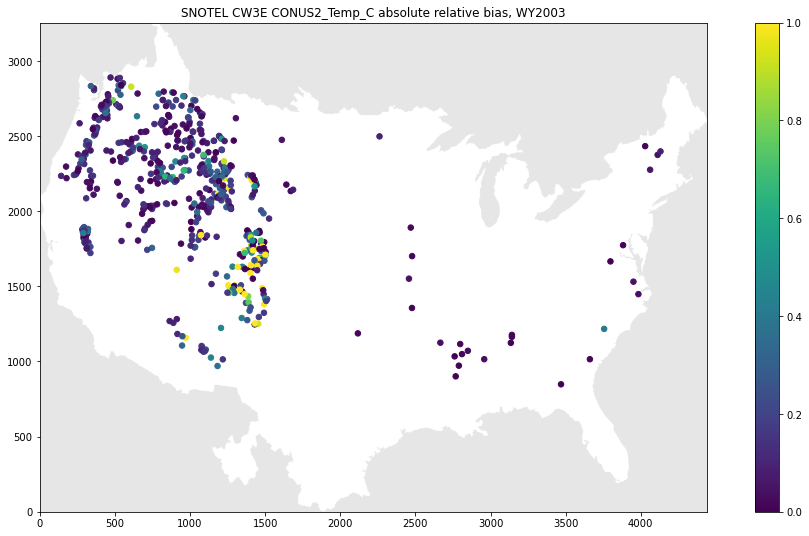

In [18]:
### Absolute Relative Bias
### Good values are closer to 0.0
fig = plt.figure(figsize=(17,9), dpi=72)
plt.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
plt.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.absrelbias, s=30, vmin = 0, vmax = 1)
plt.colorbar()
plt.title(f'SNOTEL CW3E {variable} absolute relative bias, WY{water_year}')
plt.savefig(f'{plot_dir}/SNOTEL_CW3E_{variable}_AbsRelBias_Map.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
    

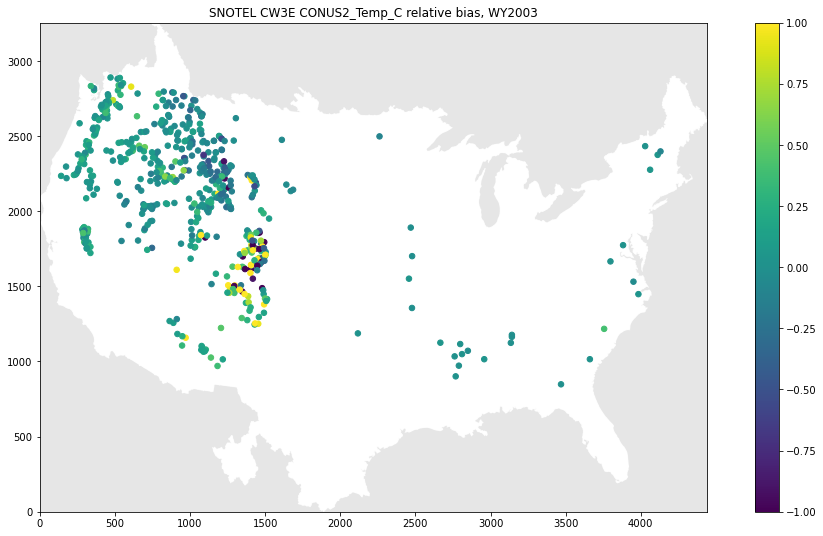

In [19]:
### Relative Bias
### Good values are closer to 0.0, positive is PF overestimation, negative is PF underestimation
fig = plt.figure(figsize=(17,9), dpi=72)
plt.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
plt.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.bias, s=30, vmin = -1, vmax = 1)
plt.colorbar()
plt.title(f'SNOTEL CW3E {variable} relative bias, WY{water_year}')
plt.savefig(f'{plot_dir}/SNOTEL_CW3E_{variable}_RelBias_Map.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
    

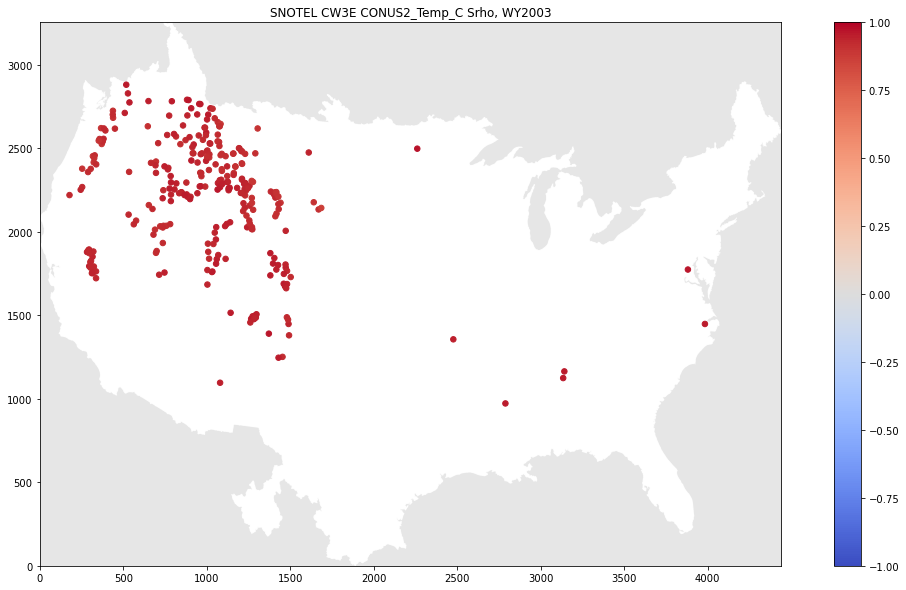

In [20]:
### Spearmsn's Rho
### Good values are closer to -1 and 1, zero is no correlation
fig = plt.figure(figsize=(19,10), dpi=72)
plt.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
plt.scatter(stats_df.conus2_x,stats_df.conus2_y, c=stats_df.srho, s=30, vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.colorbar()
plt.title(f'SNOTEL CW3E {variable} Srho, WY{water_year}')
plt.savefig(f'{plot_dir}/SNOTEL_CW3E_{variable}_SpearmansRho_Map.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
    

## Make SNOTEL-CONUS2 timeseries plots 
Plot a timeseries at each station for SNOTEL Temperature observations and PF-CONUS2

In [36]:
len(snotel_data.columns)

365

In [45]:
### Make a plot of CONUS2 vs observed
xlength = range(len(snotel_data.columns))
xlength = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in pfdata.columns]

for i in range(len(pfdata.index)):
    gage = snotel_data.index[i]
    station_name = snotel_metadata['site_name'][gage]
    state = snotel_metadata['state'][gage]

    # make hydrographs
    fig, ax = plt.subplots(figsize=(7,5), dpi = 200)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.plot(xlength, pfdata.loc[gage],label= 'CW3E')
    ax.plot(xlength, snotel_data.loc[gage],label= 'SNOTEL')
    #plt.gcf().autofmt_xdate()
    ax.set_ylabel('temp [C]')
    #plt.xlabel('Days')
    plt.title(f'Mean Daily Temperature - {station_name}, {state}')
    plt.annotate(f'Bias: {round(stats_df.bias.iloc[i],3)}\nSrho: {round(stats_df.srho.iloc[i],3)}',xy=(0.8,0.05), xycoords = 'axes fraction')
    ax.legend()
    plt.savefig(f'{plot_dir}/Timeseries_2003_Temp_SNOTEL/Timeseries_{snotel_data.index[i]}_cms.png',facecolor='white', transparent=False, bbox_inches="tight")
    plt.close()

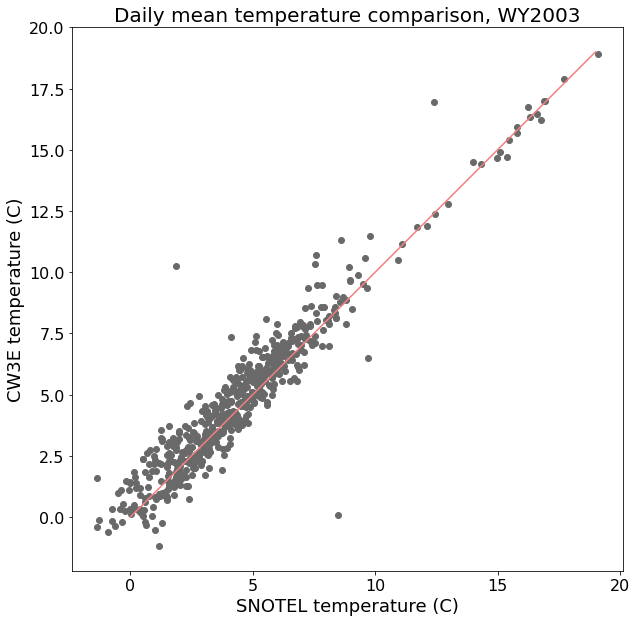

In [65]:
# Scatter plot of daily mean flow for  WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()

ax.scatter(stats_df['SNOTEL_mean_T_C'], stats_df['CW3E_mean_T_C'], color = 'dimgrey')
ax.plot(range(20), color = 'lightcoral')
plt.xlabel('SNOTEL temperature (C)',fontsize=18)
plt.ylabel('CW3E temperature (C)',fontsize=18)
plt.title('Daily mean temperature comparison, WY2003',fontsize=20)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# square plot
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'{plot_dir}/SNOTEL_CW3E_meanTemp_scatter_WY{water_year}.png')


### Geopandas Test Code

In [ ]:
import geopandas as gpd

# Create a GeoDataFrame from a CSV file with longitude and latitude columns
df = gpd.read_csv(f'Summary_Stations_SNOTEL_{variable}_CONUS2_WY{water_year}.csv')
geometry = gpd.points_from_xy(df.longitude, df.latitude)
gdf = gpd.GeoDataFrame(df, geometry=geometry)


In [ ]:
# Read in the shapefile
shapefile = gpd.read_file('shapefile.shp')

# Plot the shapefile
ax = shapefile.plot()

# Plot the GeoDataFrame on top of the shapefile
gdf.plot(ax=ax, color='red', markersize=5)